[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia
%pip install -U langchain_tavily

## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [6]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
# If you are on the EU instance:
os.environ["LANGSMITH_ENDPOINT"] = "https://eu.api.smith.langchain.com"

In [7]:
import langchain, langchain_core, langsmith
print(langchain.__version__)
print(langchain_core.__version__)
print(langsmith.__version__)

1.1.3
1.1.3
0.3.45


## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [8]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

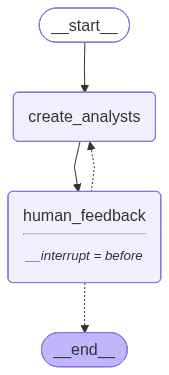

In [9]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic, human_analyst_feedback=human_analyst_feedback, max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
# Input
max_analysts = 3 
topic = "The pain points the insurance company Allianz have in the claims process for travel cancellations"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Sophia Tran
Affiliation: Allianz
Role: Claims Process Efficiency Expert
Description: Sophia focuses on identifying bottlenecks and inefficiencies in the travel cancellation claims process. Her primary concern is to streamline operations to reduce processing time and improve customer satisfaction. She is motivated by the need to enhance the overall efficiency of the claims process, ensuring that customers receive timely resolutions.
--------------------------------------------------
Name: Liam Patel
Affiliation: Allianz
Role: Customer Experience Analyst
Description: Liam is dedicated to understanding the customer journey during the travel cancellation claims process. His focus is on identifying pain points from the customer's perspective and finding ways to improve communication and service delivery. He is driven by the goal of enhancing customer satisfaction and loyalty by ensuring a seamless and transparent claims experience.
--------------------------------------------------
Na

In [34]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [35]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone with data & architecture skills"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d66fd-b00a-6825-8008-68398acfa522'}}

In [36]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: John Smith
Affiliation: Allianz Claims Department
Role: Claims Process Efficiency Analyst
Description: John focuses on identifying bottlenecks and inefficiencies in the travel cancellation claims process. His primary concern is to streamline operations to reduce processing time and improve customer satisfaction. He is motivated by the need to enhance operational efficiency and reduce costs associated with prolonged claims processing.
--------------------------------------------------
Name: Emily Johnson
Affiliation: Allianz Customer Experience Team
Role: Customer Satisfaction Analyst
Description: Emily is dedicated to understanding the customer experience during the travel cancellation claims process. Her focus is on identifying pain points from the customer's perspective, such as communication gaps and delays. She aims to improve the overall customer journey and satisfaction by advocating for clearer communication and faster resolution times.
------------------------------------

In [37]:
# If we are satisfied, then we simply supply no feedback
further_feedback = None # because we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d66ff-068c-62b7-800a-78f494a734f7'}}

In [38]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [39]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [40]:
final_state.next

()

In [41]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Tran
Affiliation: Allianz
Role: Claims Process Efficiency Expert
Description: Sophia focuses on identifying bottlenecks and inefficiencies in the travel cancellation claims process. Her main concern is to streamline operations to reduce processing time and improve customer satisfaction. She is motivated by the need to enhance the overall efficiency of the claims process, ensuring that customers receive timely resolutions.
--------------------------------------------------
Name: Liam Patel
Affiliation: Allianz
Role: Customer Experience Analyst
Description: Liam is dedicated to understanding the customer journey during the travel cancellation claims process. His focus is on identifying pain points from the customer's perspective and finding ways to improve communication and service delivery. He is driven by the goal of enhancing customer satisfaction and loyalty by ensuring a seamless and transparent claims experience.
--------------------------------------------------
Name:

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [42]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [43]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [44]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [45]:
# Web search tool
from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3)

In [46]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

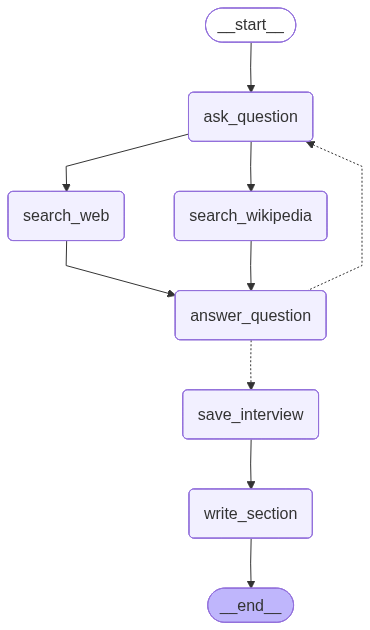

In [47]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include the sources of your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of technical pain points and the source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [48]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Allianz', name='Sophia Tran', role='Claims Process Efficiency Expert', description='Sophia focuses on identifying bottlenecks and inefficiencies in the travel cancellation claims process. Her main concern is to streamline operations to reduce processing time and improve customer satisfaction. She is motivated by the need to enhance the overall efficiency of the claims process, ensuring that customers receive timely resolutions.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.     TO BE CHECKED AND POSSIBLY REPLACED OR REMOVED

In [49]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 5}, thread)
Markdown(interview['sections'][0])

## Streamlining Travel Cancellation Claims: Overcoming Bottlenecks and Enhancing Efficiency

### Summary

The travel cancellation claims process is a critical component of customer service for insurance companies, yet it is often fraught with inefficiencies and bottlenecks that lead to customer dissatisfaction. The need to streamline operations is paramount to reduce processing time and improve customer satisfaction. Recent insights into the claims process reveal both challenges and innovative solutions that can transform the experience for customers and insurers alike.

1. **Inconsistent Communication and Delays**: Customers frequently report inconsistent communication and prolonged processing times when filing claims. For instance, some users have experienced delays of up to nine months before receiving refunds, indicating a significant bottleneck in the claims process [1]. This inconsistency can lead to frustration and a lack of trust in the insurance provider.

2. **Complex Documentation Requirements**: The requirement for extensive documentation can be a barrier to efficient claims processing. Customers must submit detailed evidence of trip cancellations and reimbursement amounts, which can be cumbersome and time-consuming [2]. This complexity often results in claims being denied or delayed due to incomplete submissions.

3. **Technological Innovations**: Allianz has made strides in modernizing the claims process through technological innovations. The introduction of remote video assessments via SightCall has allowed adjusters to evaluate claims damage remotely, significantly reducing the need for in-person assessments and cutting down on unnecessary travel [3]. This innovation has led to increased efficiency and customer satisfaction.

4. **AI-Driven Solutions**: The deployment of agentic AI solutions, such as Project Nemo, has revolutionized the processing of simple claims by reducing processing times from days to hours. This approach not only enhances productivity but also improves customer satisfaction by providing quicker resolutions [4]. The AI-enhanced claims portal further simplifies the process, making it more user-friendly and efficient [5].

5. **Customer Experience Variability**: While some customers report a straightforward and satisfactory claims process, others experience significant challenges. This variability suggests that while improvements have been made, there is still work to be done to ensure a consistently positive experience for all customers [6].

In conclusion, while there are notable advancements in the travel cancellation claims process, such as the use of AI and remote assessments, there remain significant areas for improvement. Addressing communication inconsistencies, simplifying documentation requirements, and ensuring uniform customer experiences are essential steps towards a more efficient and customer-friendly claims process.

### Sources
[1] https://www.facebook.com/groups/1903318183220086/posts/4037153833169833/  
[2] https://www.allianztravelinsurance.com/travel/trip-cancellation/dealing-with-a-trip-cancellation.htm  
[3] https://sightcall.com/case-studies/allianz/  
[4] https://www.allianz.com/en/mediacenter/news/articles/251103-when-the-storm-clears-so-should-the-claim-queue.html  
[5] https://www.insurtechinsights.com/allianz-partners-launches-new-ai-enhanced-claims-portal/  
[6] https://www.consumeraffairs.com/travel/access_america.html?page=5  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [51]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

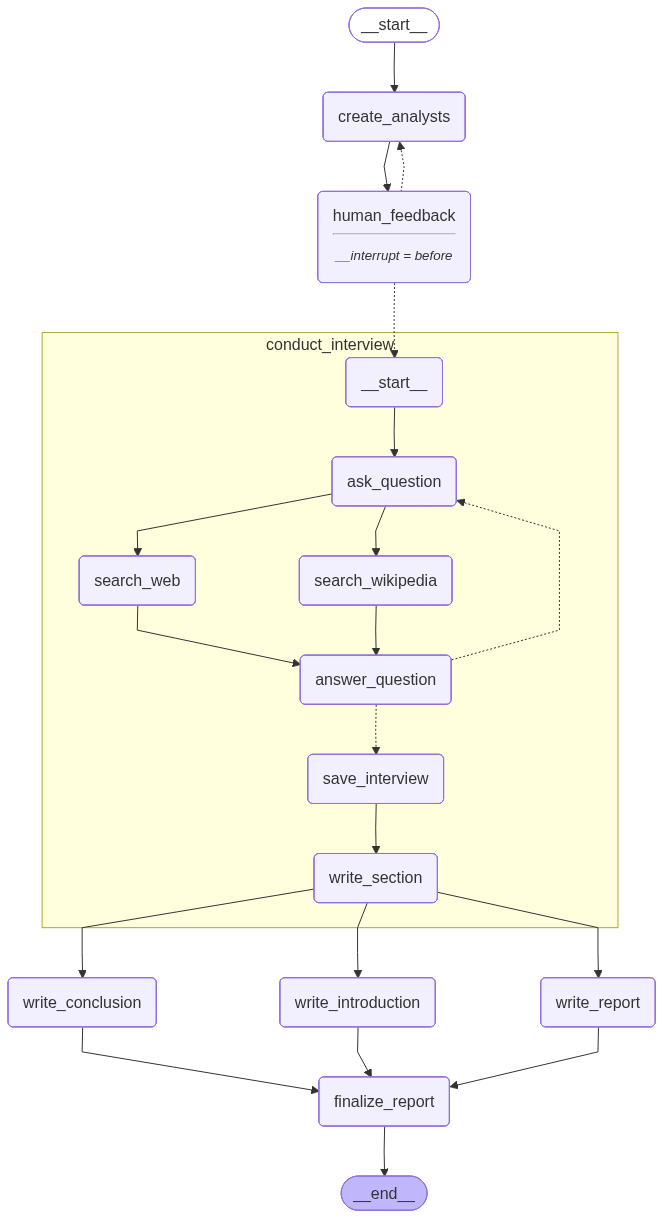

In [52]:
from langgraph.types import Send # updated in 1.0
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Create a numbered list of technical pain points and the source documents, as you use them
5. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [53]:
# Inputs
max_analysts = 3 
topic = "The pain points the insurance company Allianz have for the Complex Documentation Requirements in the claims process for travel cancellations "
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Allianz
Role: Process Optimization Specialist
Description: Dr. Carter focuses on streamlining the claims process by identifying bottlenecks and inefficiencies in the documentation requirements. Her primary concern is to reduce the complexity and time required for processing travel cancellation claims, ensuring a smoother experience for both customers and employees.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Customer Experience Research Group
Role: Customer Experience Analyst
Description: Mr. Smith is dedicated to understanding the customer journey and pain points associated with the claims process. He aims to enhance customer satisfaction by advocating for clearer communication and simplified documentation requirements, ensuring that customers are not overwhelmed by the complexity of the claims process.
--------------------------------------------------
Name: Ms. Sarah Lee
Affiliation: Regulatory Compliance I

In [54]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": "add a data & AI architect"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d670e-3aa7-6df0-8002-b503ee415e73'}}

In [55]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Allianz
Role: Process Optimization Specialist
Description: Dr. Carter focuses on streamlining the claims process by identifying bottlenecks and inefficiencies in the documentation requirements. Her primary concern is to reduce the complexity and time required for processing travel cancellation claims, ensuring a smoother experience for both customers and employees.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Customer Experience Research Group
Role: Customer Experience Analyst
Description: Mr. Smith is dedicated to understanding the customer journey and pain points associated with the claims process. He aims to enhance customer satisfaction by advocating for clearer communication and simplified documentation requirements, ensuring that customers are not overwhelmed by the complexity of the claims process.
--------------------------------------------------
Name: Ms. Sarah Lee
Affiliation: Regulatory Compliance I

In [56]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d6713-b28b-635c-8004-e9673964a8e1'}}

In [57]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [58]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Navigating the Complexities of Travel Insurance Claims: A Path to Simplification

## Introduction

In the intricate world of travel insurance, the claims process often presents significant challenges, particularly due to complex documentation requirements. This report delves into the pain points faced by Allianz in managing travel cancellation claims, highlighting the extensive documentation needed, cumbersome filing procedures, and the potential for claim denials. Customer frustration and delays further exacerbate these issues, underscoring the need for streamlined processes. By exploring the integration of AI technologies, such as Project Nemo and the Universal Claims Portal, this report outlines how Allianz can enhance efficiency, improve customer satisfaction, and maintain its reputation as a leader in travel insurance.

---



The insurance company Allianz faces several technical pain points in the claims process for travel cancellations, primarily due to complex documentation requirements. These challenges impact both customer satisfaction and operational efficiency, necessitating a streamlined approach to claims processing.

1. **Extensive Documentation Requirements**: Claimants are required to provide detailed documentation to substantiate claims, such as canceled flights, medical emergencies, or lost luggage. This requirement can be overwhelming and time-consuming, leading to customer frustration [1][4].

2. **Complex Filing Procedures**: Despite offering multiple ways to file a claim, Allianz's process remains cumbersome. Customers must navigate the insurer's website and follow specific steps, which can deter them from filing claims [2].

3. **Potential for Claim Denials**: Claims may be denied if documentation is incomplete or overlaps with other insurance policies. This adds complexity and can lead to dissatisfaction, with some customers needing legal intervention [2][4].

4. **Customer Frustration and Delays**: The need for patience and comprehensive paperwork can lead to customer dissatisfaction, as the process is often described as challenging and time-consuming [3].

5. **Need for a Documentation Checklist**: A comprehensive checklist could help ensure customers have all required documents, streamlining the process and reducing the likelihood of claim denials [4].

6. **Manual Processing Delays**: Traditional claims processing is time-consuming, often taking days to complete. AI solutions like Project Nemo have shown potential in drastically reducing processing times [1].

7. **Complexity in Claims Handling**: The complexity of insurance processes can lead to inefficiencies. AI initiatives like the Insurance Copilot aim to streamline workflows and automate tasks, reducing the burden on human agents [3].

8. **Balancing Automation and Human Oversight**: While AI can enhance efficiency, maintaining human oversight is crucial, especially in decision-making processes like claim denials. Allianz Partners USA ensures that human agents remain integral to the process [2].

Allianz has made strides in addressing these pain points by implementing AI-driven initiatives such as Project Nemo and the Universal Claims Portal, which have significantly reduced processing times and improved customer satisfaction. However, further simplification of documentation requirements and clearer guidance are necessary to enhance customer satisfaction and retention. By leveraging technology and maintaining a balance between automation and human oversight, Allianz can continue to improve its claims process and solidify its reputation as a customer-centric travel insurance provider.


---

## Conclusion

The complexities of documentation requirements in Allianz's travel insurance claims process present significant challenges that impact customer satisfaction and operational efficiency. Extensive documentation demands, complex filing procedures, and the potential for claim denials contribute to customer frustration and delays. Despite these hurdles, Allianz has maintained a high customer satisfaction rate by leveraging best practices and technology. The introduction of AI-driven solutions, such as Project Nemo and the Universal Claims Portal, highlights Allianz's commitment to transforming claims processing. By simplifying documentation requirements and enhancing automation, Allianz can further improve customer satisfaction and streamline operations, solidifying its reputation as a leader in customer-centric travel insurance.

## Sources
[1] https://www.allianztravelinsurance.com/travel/planning/easy-to-file-travel-insurance-claim.htm  
[2] https://www.forthepeople.com/blog/how-do-i-file-claim-allianz-travel-insurance/  
[3] https://www.facebook.com/groups/1373361046396315/posts/2214550762277335/  
[4] https://community.ricksteves.com/travel-forum/budget-tips/recent-positive-experience-with-allianz-for-trip-cancellation  
[5] https://travelprofessionalnews.com/allianz-report-released-today-on-customer-experience-and-travel-protection-technologies/amp/  
[6] https://www.allianz.com/en/mediacenter/news/articles/251103-when-the-storm-clears-so-should-the-claim-queue.html  
[7] https://fintech.global/2024/09/19/allianz-partners-usa-unveils-ai-powered-universal-claims-portal-for-faster-claims-processing/  
[8] https://www.allianz.com/en/mediacenter/news/articles/250205-smarter-claims-management-smoother-settlements.html

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r